(39209, 32, 32, 3) (39209,)
(31367, 32, 32, 3) (7842, 32, 32, 3) (31367,) (7842,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 264s 241ms/step - accuracy: 0.3384 - loss: 2.6318 - val_accuracy: 0.6012 - val_loss: 1.2069
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 227s 231ms/step - accuracy: 0.5435 - loss: 1.3737 - val_accuracy: 0.6744 - val_loss: 0.9529
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 208s 212ms/step - accuracy: 0.6095 - loss: 1.1543 - val_accuracy: 0.7317 - val_loss: 0.8144
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 216s 221ms/step - accuracy: 0.6543 - loss: 1.0257 - val_accuracy: 0.7325 - val_loss: 0.7859
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 217s 221ms/step - accuracy: 0.6844 - loss: 0.9278 - val_accuracy: 0.7786 - val_loss: 0.6841
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 210s 214ms/step - accuracy: 0.7045 - loss: 0.8605 - val_accuracy: 0.7902 - val_loss: 0.6412
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 226s 230ms/step - accuracy: 0.7204 

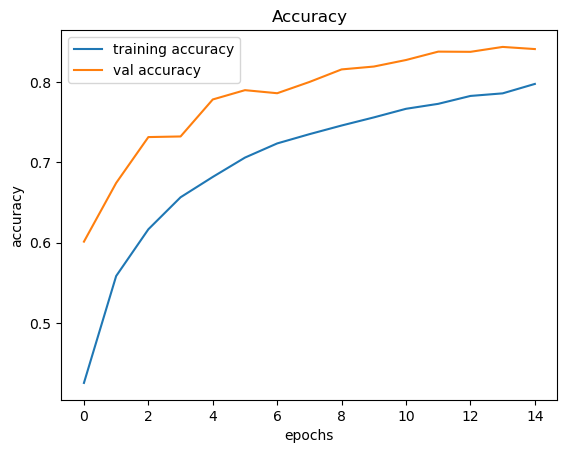

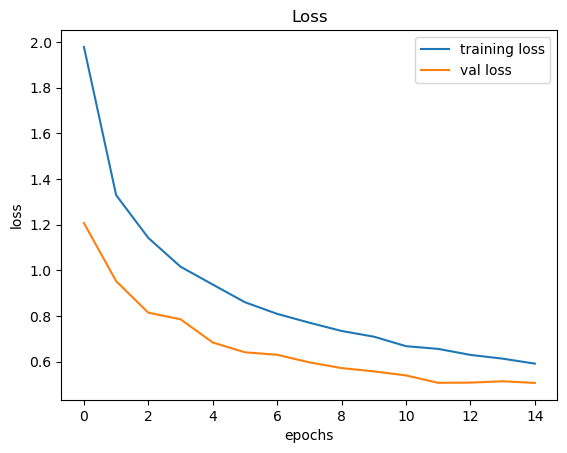

395/395 ━━━━━━━━━━━━━━━━━━━━ 93s 204ms/step


0.5140142517814726


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input

# Data preparation
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(cur_path, 'train', str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((32, 32))  # Resize to 32x32 pixels
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(f"Error loading image {a}: {e}")

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Preprocessing the data for ResNet50
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

# Using the ResNet50 model with pre-trained weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Building the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

# Freezing the base model layers
base_model.trainable = False

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))
model.save("my_model_resnet50.h5")

# Plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Testing accuracy on test dataset
y_test_df = pd.read_csv('Test.csv')

labels = y_test_df["ClassId"].values
imgs = y_test_df["Path"].values

data = []

for img in imgs:
    image = Image.open(img)
    image = image.resize((32, 32))  # Resize to 32x32 pixels
    data.append(np.array(image))

X_test = np.array(data)
X_test = preprocess_input(X_test)

pred = np.argmax(model.predict(X_test), axis=1)

# Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

model.save("traffic_classifier_resnet50.h5")
